# Mask R-CNN Training

## Introduction Mask R-CNN - Training

Useful links

* https://github.com/leekunhee/Mask_RCNN
* https://github.com/ahmedfgad/Mask-RCNN-TF2
* https://bitbucket.org/rewintous/isic_2018_mrcnn_submit/src/master/

### Connecting to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up google collaboration

In [ ]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [ ]:
!lscpu |grep 'Model name'

Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

12G


In [ ]:
#GPU count and name
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# !apt update && apt install cuda-11-8

### Importing libraries

In [ ]:
#configurando o ambiente
!pip install -r "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/requirements.txt"

In [ ]:
# import packages
import os
import sys
import numpy as np
import tensorflow as tf
import skimage.io
import argparse
import imutils
import random
import cv2
import warnings
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

from imutils import paths

#Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/skin_cancer/models/mask_rcnn")
sys.path.append(ROOT_DIR)  #To find local version of the library

from imgaug import augmenters as iaa
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn import utils

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')

## Configurations

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.11.0

Num GPUs Available:  0


### Environment variables

In [ ]:
TASK = 2

if TASK == 1:
  #/content/drive/MyDrive/skin_cancer/assets/data_aug_dataset_complete/npy/
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/"
  os.environ["TASK"] = "task_1_lesion_segmentation"
  os.environ["NUMBER_OF_CLASSES"] = "1"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Training_GroundTruth")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str("/content/drive/MyDrive/skin_cancer/assets/img_dataset/" +  "ISIC2018_Task1_Test_GroundTruth")
elif TASK == 2:
  # os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/true_dataset/data_aug_dataset/"
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/utils/sandbox_2/attribute_pigment_network/"
  os.environ["TASK"] = "task_2_lesion_attribute_detection"
  os.environ["NUMBER_OF_CLASSES"] = "1"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Training_GroundTruth_v3")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str("/content/drive/MyDrive/skin_cancer/assets/img_dataset/" + "ISIC2018_Task2_Test_GroundTruth")

if TASK in [1, 2]:
  os.environ["TRAINING_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Training_Input")
  os.environ["VALIDATION_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Validation_Input")
  os.environ["TEST_IMAGES_PATH"] = str("/content/drive/MyDrive/skin_cancer/assets/img_dataset/" + "ISIC2018_Task1_and_2_Test_Input")

  os.environ["VALIDATION_COUNT"] = "100"
  os.environ["TRAINING_COUNT"] = "2594"
  os.environ["TEST_COUNT"] = "1000"

### Global variables

In [ ]:
#initialize the path to the Mask R-CNN pre-trained on COCO
COCO_PATH = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/mask_rcnn_coco.h5" # "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/lesion20230313T2032/mask_rcnn_lesion_0030.h5"
COCO_PATH = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/lesion20240628T0004/mask_rcnn_lesion_0100.h5"


#initialize the name of the directory where logs and output model snapshots will be stored
LOGS_AND_MODEL_DIR = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights"

print(f"Quantidade de imagens de treino: {int(os.environ['TRAINING_COUNT'])} ({100 * int(os.environ['TRAINING_COUNT'])/(int(os.environ['TRAINING_COUNT']) + int(os.environ['VALIDATION_COUNT']))} %)")
print(f"Quantidade de imagens de validacao: {int(os.environ['VALIDATION_COUNT'])} ({100 * int(os.environ['VALIDATION_COUNT'])/(int(os.environ['TRAINING_COUNT']) + int(os.environ['VALIDATION_COUNT']))} %)")

Quantidade de imagens de treino: 3 (75.0 %)
Quantidade de imagens de validacao: 1 (25.0 %)


## Model

### Model config

In [ ]:
class LesionConfig(Config):
	"""Configuration for training on the nucleus segmentation dataset."""

	#give the configuration a recognizable name
	NAME = "lesion"

	# set the number of GPUs to use training along with the number of
	# images per GPU (which may have to be tuned depending on how much memory your GPU has)
	GPU_COUNT = 1
	IMAGES_PER_GPU = 4
	IMAGES_PER_GPU = 1

	# number of classes (+ 1 for the background)
	NUM_CLASSES = int(os.environ["NUMBER_OF_CLASSES"]) + 1

	# set the number of steps per training epoch and validation cycle
	STEPS_PER_EPOCH = (int(os.environ["TRAINING_COUNT"]) - int(os.environ["VALIDATION_COUNT"])) // IMAGES_PER_GPU
	VALIDATION_STEPS = max(1, int(os.environ["VALIDATION_COUNT"]) // IMAGES_PER_GPU)

	# Don't exclude based on confidence. Since we have two classes
  # then 0.5 is the minimum anyway as it picks between nucleus and BG
	DETECTION_MIN_CONFIDENCE = 0

	# Backbone network architecture
	# Supported values are: resnet50, resnet101
	BACKBONE = "resnet50"

	# Input image resizing
	# Random crops of size 512x512 vs SQUARE 768 vs pad64 todo
	IMAGE_RESIZE_MODE = "square"
	IMAGE_MIN_DIM = 256
	IMAGE_MAX_DIM = 256

	# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

	# ROIs kept after non-maximum supression (training and inference)
	POST_NMS_ROIS_TRAINING = 1000
	POST_NMS_ROIS_INFERENCE = 2000

	# Non-max suppression threshold to filter RPN proposals.
	# You can increase this during training to generate more propsals.
	RPN_NMS_THRESHOLD = 0.9

	# How many anchors per image to use for RPN training
	RPN_TRAIN_ANCHORS_PER_IMAGE = 64

	# Number of ROIs per image to feed to classifier/mask heads
	# The Mask RCNN paper uses 512 but often the RPN doesn't generate
	# enough positive proposals to fill this and keep a positive:negative
	# ratio of 1:3. You can increase the number of proposals by adjusting
	# the RPN NMS threshold.
	TRAIN_ROIS_PER_IMAGE = 128

	# Maximum number of ground truth instances to use in one image
	MAX_GT_INSTANCES = 200

	# # Max number of final detections per image
	DETECTION_MAX_INSTANCES = 400

	# my configs
	# LEARNING_RATE = 0.01

	# If enabled, resizes instance masks to a smaller size to reduce
	# memory load. Recommended when using high-resolution images.
	USE_MINI_MASK = False
	MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

class LesionInferenceConfig(LesionConfig):
	# Set batch size to 1 to run one image at a time
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	# Don't resize imager for inferencing
  # IMAGE_RESIZE_MODE = "pad64"

	# Non-max suppression threshold to filter RPN proposals.
	# You can increase this during training to generate more propsals.
	RPN_NMS_THRESHOLD = 0.7

	# #set the minimum detection confidence (used to prune out false positive detections)
	# DETECTION_MIN_CONFIDENCE = 0.9

#initialize the training configuration
config = LesionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

### Dataset

In [ ]:
class LesionDataset(utils.Dataset):
	def __init__(self, subset, class_map=None):
		super().__init__(class_map)
		self.image_paths = None
		self.ground_truth_dir = None
		self.subset = subset

	def configure_dataset(self):
		# reducing the size of the dataset
		if self.subset == "train":
			self.image_paths = self.image_paths[:int(os.environ["TRAINING_COUNT"])]
		elif self.subset == "val":
			self.image_paths = self.image_paths[:int(os.environ["VALIDATION_COUNT"])]
		elif self.subset == "test":
			self.image_paths = self.image_paths[:int(os.environ["TEST_COUNT"])]

		print(f"len(self.image_paths) {len(self.image_paths)}")

	def setup_classes(self):
		if os.environ["NUMBER_OF_CLASSES"] == "1":
			self.add_class("skinroi", 1, "skinroi")
		else:
			self.add_class("skinroi", 1, "globules")
			self.add_class("skinroi", 2, "milia_like_cyst")
			self.add_class("skinroi", 3, "negative_network")
			self.add_class("skinroi", 4, "pigment_network")
			self.add_class("skinroi", 5, "streaks")

	def load_skin(self, dataset_dir, ground_truth_dir):
		self.ground_truth_dir = ground_truth_dir
		self.setup_classes() # Add classes

		self.image_paths = sorted(list(paths.list_images(dataset_dir)))
		self.configure_dataset()

		# Add images
		for image_path in self.image_paths:
				split_names = os.path.split(str(image_path))
				fn, ext = os.path.splitext(split_names[-1])
				self.add_image("skinroi", image_id=fn, path=str(image_path))

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		masks = []

		for class_id in range(1, self.num_classes):
				mask_path = os.path.join(str(self.ground_truth_dir), self.format_mask_name(class_id, info))
				# Read mask files from .png image
				masks.append(skimage.io.imread(mask_path).astype(np.bool))
		mask = np.stack(masks, axis=-1)

		# Return mask, and array of class IDs of each instance. Since we have
		# one class ID, we return an array of ones
		return mask, np.asarray(range(1,self.num_classes))

	def format_mask_name(self, class_id, info):
		if os.environ["NUMBER_OF_CLASSES"] == "1":
			return info['id'] + "_segmentation.png"
		else:
			return info['id'] + "_attribute_" + self.class_names[class_id] + ".png"

	def image_reference(self, image_id):
		"""Return the path of the image."""
		info = self.image_info[image_id]
		if info["source"] == "skinroi":
				return info["id"]
		else:
				super(self.__class__, self).image_reference(image_id)

In [ ]:
#load the training dataset
dataset_train = LesionDataset("train")
dataset_train.load_skin(os.environ["TRAINING_IMAGES_PATH"], os.environ["TRAINING_MASKS_PATH"])
dataset_train.prepare()

#load the validation dataset
dataset_val = LesionDataset("val")
dataset_val.load_skin(os.environ["VALIDATION_IMAGES_PATH"], os.environ["VALIDATION_MASKS_PATH"])
dataset_val.prepare()

# #load the test dataset
# dataset_test = LesionDataset("test")
# dataset_test.load_skin(os.environ["TEST_IMAGES_PATH"], os.environ["TEST_MASKS_PATH"])
# dataset_test.prepare()

len(self.image_paths) 3
len(self.image_paths) 1


TREINO



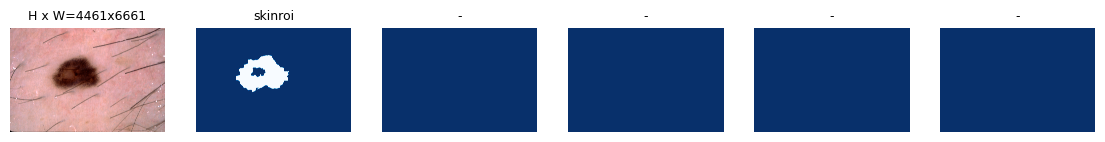


VALIDATION



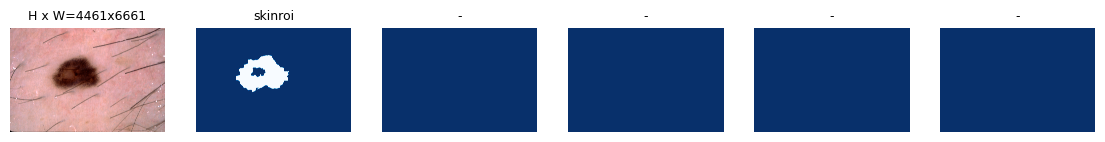

In [ ]:
print("TREINO\n")

#determine a sample of training image indexes and loop over them
for i in np.random.choice(dataset_train.image_ids, 1):
  #load the image and masks for the sampled image
  # print(f"Investigating image index: {i}\n")

  image = dataset_train.load_image(i)
  (masks, class_ids) = dataset_train.load_mask(i)

  #visualize the masks for the current image
  visualize.display_top_masks(image, masks, class_ids, dataset_train.class_names, 5)

print("\nVALIDATION\n")

#determine a sample of training image indexes and loop over them
for i in np.random.choice(dataset_val.image_ids, 1):
  #load the image and masks for the sampled image
  # print(f"Investigating image index: {i}\n")

  image = dataset_val.load_image(i)
  (masks, class_ids) = dataset_val.load_mask(i)

  #visualize the masks for the current image
  visualize.display_top_masks(image, masks, class_ids, dataset_val.class_names, 5)

# print("\nTEST\n")

# #determine a sample of training image indexes and loop over them
# for i in np.random.choice(dataset_test.image_ids, 1):
#   #load the image and masks for the sampled image
#   # print(f"Investigating image index: {i}\n")

#   image = dataset_test.load_image(i)
#   (masks, class_ids) = dataset_test.load_mask(i)

#   #visualize the masks for the current image
#   visualize.display_top_masks(image, masks, class_ids, dataset_test.class_names, 5)

## Training

### Create Model

In [ ]:
# initialize the image augmentation process
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html

# aug = iaa.SomeOf((0, 2), [
#   iaa.Crop(px=(32, 32, 32, 32)),
#   iaa.Fliplr(0.5),
#   iaa.Flipud(0.5),
#   iaa.OneOf(
#     [
#       iaa.Affine(rotate=45),
#       iaa.Affine(rotate=270),
#       iaa.Affine(cval=0)
#     ]
#   ),
#   iaa.Multiply((0.8, 1.5)),
#   iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05))
# ])

aug = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

#initialize the model and load the COCO weights so we can perform fine-tuning
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_AND_MODEL_DIR)
model.load_weights(COCO_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


Re-starting from epoch 100


### Training

In [ ]:
layers = "heads" #or "all"

#train *just* the layer heads
if layers == "heads":
  model.train(
    dataset_train, dataset_val, epochs=200, layers="heads",
    learning_rate=config.LEARNING_RATE, augmentation=aug)
else: #unfreeze the body of the network and train *all* layers
  model.train(
    dataset_train, dataset_val, epochs=40, layers="all",
    learning_rate=config.LEARNING_RATE / 10, augmentation=aug)


In [ ]:
%reload_ext tensorboard

%tensorboard --logdir /content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/lesion20230601T1752/